In [5]:
import pandas as pd
from pathlib import Path
import numpy as np
from ephys_queries import db_setup_core, select_spike_times
from dotenv import load_dotenv
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [6]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [7]:
df = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: 
         (x["group_name"].isin((
            "acute_citalopram", 
            "acute_saline", 
            "shock", 
            "sham", 
            "acute_cit", 
            "acute_sal"
                ))
        ) & (
         x["cluster"] != "no_baseline")]
)

In [8]:
group_names = ["acute_citalopram", "acute_saline", "shock", 
               "sham", "acute_cit", "acute_sal"]
block_name = "pre"
fs = 30000

load_dotenv()
engine, metadata = db_setup_core()

In [9]:
session_names = df["session_name"].unique()
session = np.random.choice(session_names, 1)[0]

In [10]:
(
    df[["neuron_id", "session_name","cluster"]]
    .groupby(['session_name', "cluster"])
    .apply(len)
    .reset_index()
    .loc[lambda x: x["session_name"]==session]
)

,session_name,cluster,0
32,acute_16,fast_firing,8
33,acute_16,slow_irregular,6
34,acute_16,slow_regular,2


In [11]:
session = "hamilton_36"

In [12]:
df_spikes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
        session_names=[session]
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)

In [13]:
df_spikes = df_spikes.merge(df[["cluster", "neuron_id"]])

In [14]:
from spiketimes.df.conversion import df_to_list


_, slow_regs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_regular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, slow_irregs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_irregular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, ffs = df_to_list(df_spikes[df_spikes["cluster"] == "fast_firing"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

In [15]:
from spiketimes.plots import grouped_raster

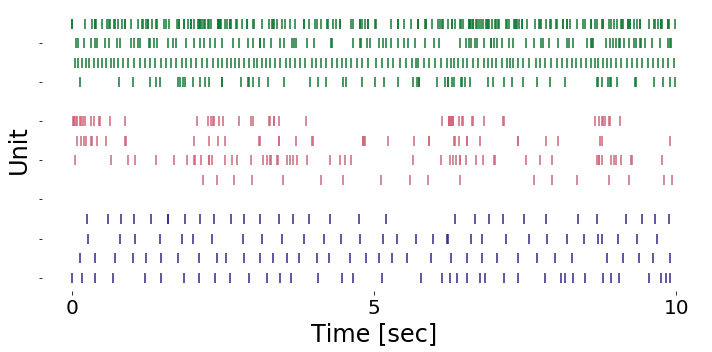

In [64]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 5))

t_start = 1060
t_stop = t_start + 10

ax = grouped_raster([slow_regs[::2], slow_irregs[5:-1:2], ffs ],
                    ["#332288", "#CC6677",  "#117733"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=1,
               plot_kwargs={"s":90},
                   ax=ax)
# ax.set_yticks(ticks=[0, 1, 3, 4, 6, 7, 8,])
ax.set_yticklabels([])

ax.set_xticks(ticks=[t_start, t_start+5, t_start+10])
ax.set_xticklabels([0, 5, 10], fontsize=20)

ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

plt.tight_layout()
plt.savefig(fig_dir / "raster.svg", dpi=300, transparent=True)

In [65]:
fig_dir

WindowsPath('C:/Users/rory/repos/ssri_analysis/figs')